## 라이브러리 import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import random
import os
import glob
from tqdm.notebook import tqdm

import albumentations as A

from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
def plot_multiple_img(img_matrix_list, title_list, ncols, main_title=""):
    fig, myaxes = plt.subplots(figsize=(20, 15), nrows=3, ncols=ncols, squeeze=False)
    fig.suptitle(main_title, fontsize = 30)
    fig.subplots_adjust(wspace=0.3)
    fig.subplots_adjust(hspace=0.3)
    for i, (img, title) in enumerate(zip(img_matrix_list, title_list)):
        myaxes[i // ncols][i % ncols].imshow(img)
        myaxes[i // ncols][i % ncols].set_title(title, fontsize=15)
    plt.show()

In [9]:
# Look at the training, testing and validation data numbers
train_data = glob.glob('./input/chest_xray/train/**/*.jpeg')
test_data = glob.glob('./input/chest_xray/test/**/*.jpeg')
val_data = glob.glob('./input/chest_xray/val/**/*.jpeg')

print(f"Training Set has: {len(train_data)} images")
print(f"Testing Set has: {len(test_data)} images")
print(f"Validation Set has: {len(val_data)} images")

Training Set has: 5216 images
Testing Set has: 624 images
Validation Set has: 16 images


## Target Value Distribution

In [10]:
DIR = "./input/chest_xray/"
sets = ["train", "test", "val"]
all_pneumonia = []
all_normal = []

for cat in sets:
    path = os.path.join(DIR, cat)
    norm = glob.glob(os.path.join(path, "NORMAL/*.jpeg"))
    pneu = glob.glob(os.path.join(path, "PNEUMONIA/*.jpeg"))
    all_normal.extend(norm)
    all_pneumonia.extend(pneu)

print(f"Total Pneumonia Images: {len(all_pneumonia)}")
print(f"Total Normal Images: {len(all_normal)}")

Total Pneumonia Images: 4273
Total Normal Images: 1583


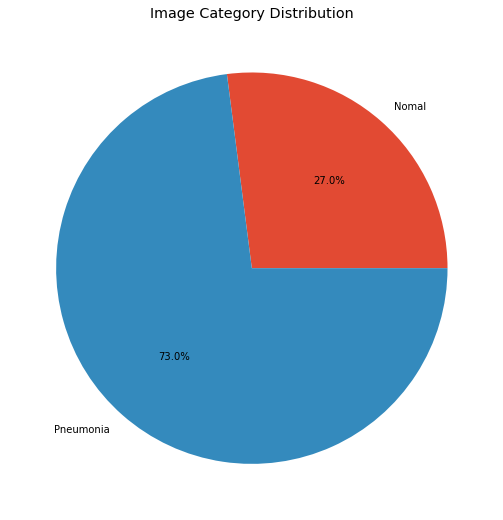

In [11]:
labels = ['Nomal', 'Pneumonia']
targets = [len(all_normal), len(all_pneumonia)]

plt.style.use("ggplot")
plt.figure(figsize=(16, 9))
plt.pie(x=targets, labels=labels, autopct="%1.1f%%")
plt.title("Image Category Distribution")
plt.show()

## EDA

In [12]:
# Shuffle and Get some images into new list
random.shuffle(all_normal)
random.shuffle(all_pneumonia)
images = all_normal[:50] + all_pneumonia[:50]

### Basic XRay Images

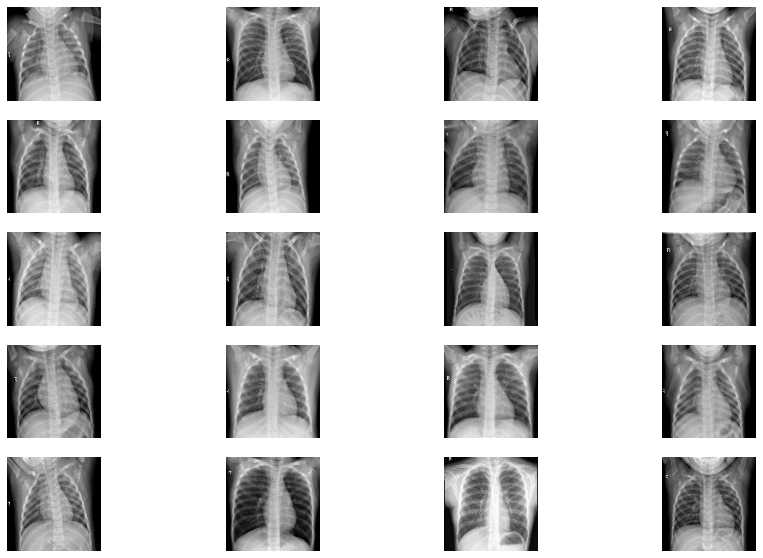

In [13]:
# 흉부 사진 20개
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 5
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (128, 128))
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

### Ben Graham's Method
(using grayscale images and then applying Gaussian Blur)

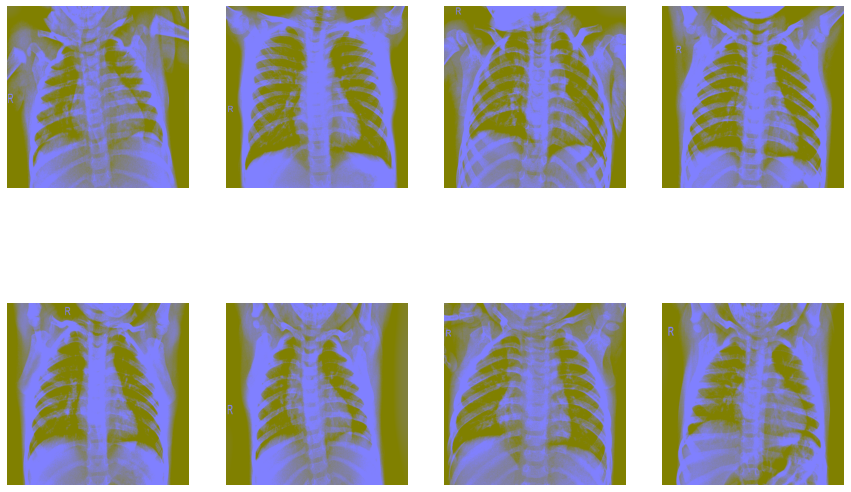

In [14]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    img = cv2.addWeighted (img, 4, cv2.GaussianBlur(img, (0,0), 512/10), -4, 128)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

### Background Subtraction

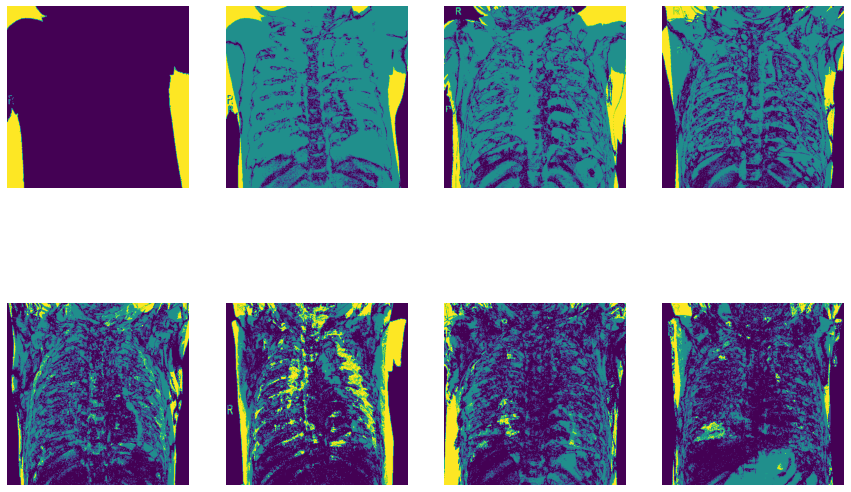

In [15]:
fgbg = cv2.createBackgroundSubtractorMOG2()

fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = fgbg.apply(img)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis(False)

In [16]:
### Fourier Method for Pixel Distribution

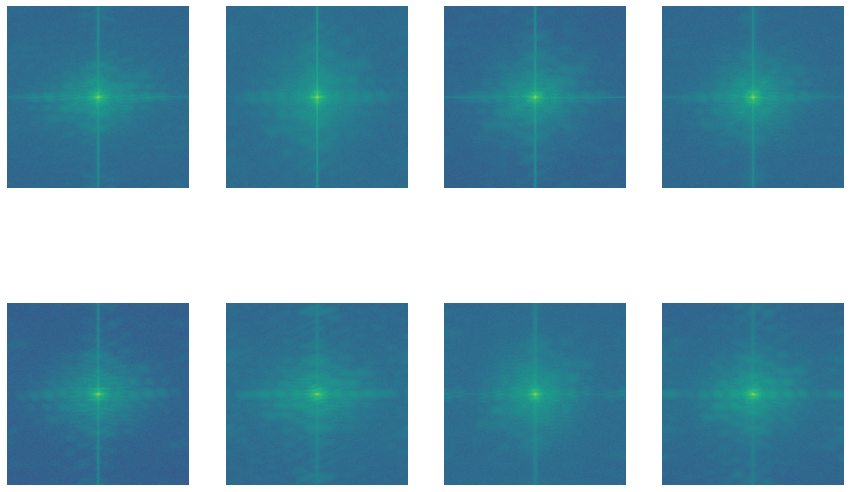

In [17]:
fig=plt.figure(figsize=(15, 10))
columns = 4; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20*np.log(np.abs(fshift))
    fig.add_subplot(rows, columns, i)
    plt.imshow(magnitude_spectrum)
    plt.axis(False)

### Albumentations Visualization
- 이미지 어그멘테이션 중 하나 (very fast, various..)
- https://hoya012.github.io/blog/albumentation_tutorial/

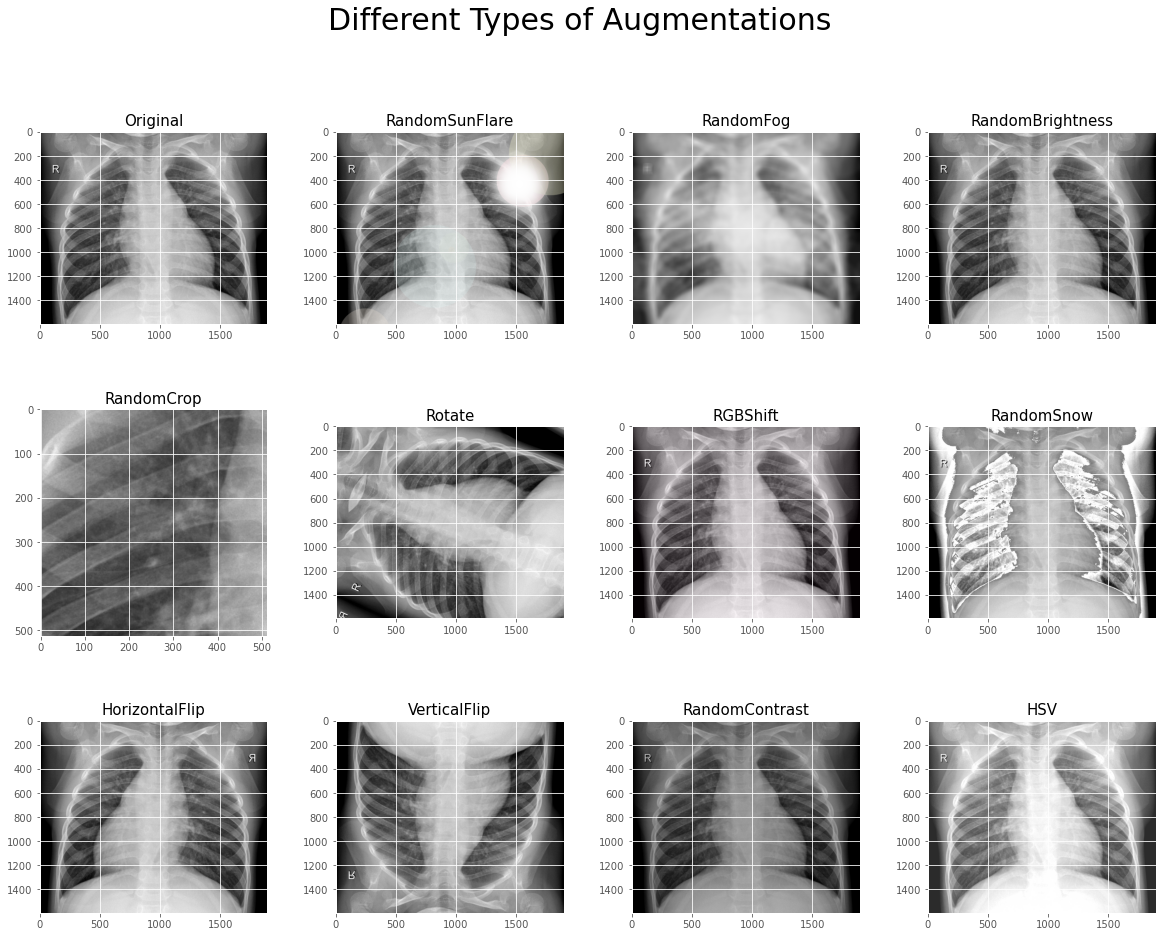

In [18]:
chosen_image = cv2.imread(images[25])
albumentation_list = [A.RandomSunFlare(p=1), A.RandomFog(p=1), A.RandomBrightness(p=1),
                      A.RandomCrop(p=1,height = 512, width = 512), A.Rotate(p=1, limit=90),
                      A.RGBShift(p=1), A.RandomSnow(p=1),
                      A.HorizontalFlip(p=1), A.VerticalFlip(p=1), A.RandomContrast(limit = 0.5,p = 1),
                      A.HueSaturationValue(p=1,hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=50)]

img_matrix_list = []
bboxes_list = []
for aug_type in albumentation_list:
    img = aug_type(image = chosen_image)['image']
    img_matrix_list.append(img)

img_matrix_list.insert(0,chosen_image)    

titles_list = ["Original","RandomSunFlare","RandomFog","RandomBrightness",
               "RandomCrop","Rotate", "RGBShift", "RandomSnow","HorizontalFlip", "VerticalFlip", "RandomContrast","HSV"]

plot_multiple_img(img_matrix_list, titles_list, ncols = 4,main_title="Different Types of Augmentations")

### Image Erosion(침식)

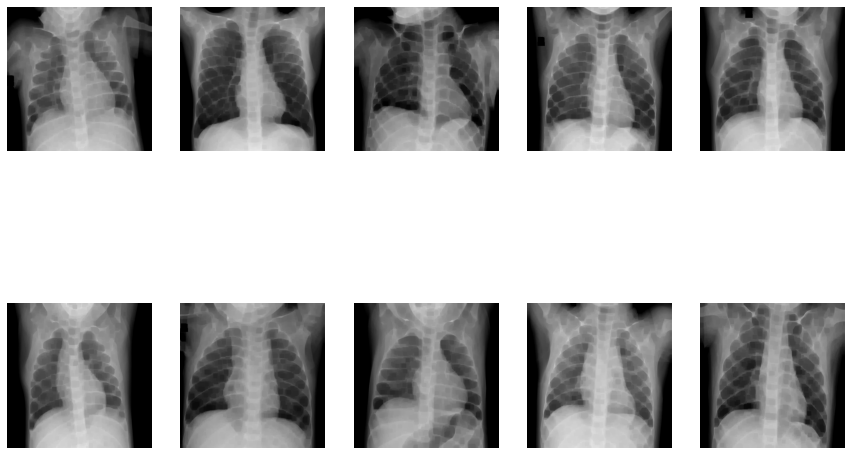

In [19]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.erode(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

### Image Dilation(팽창)

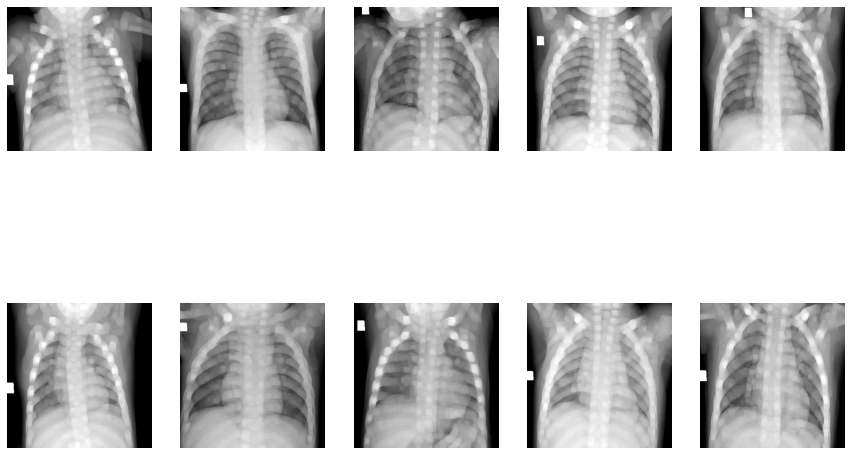

In [20]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    kernel = np.ones((5, 5), np.uint8)
    img_erosion = cv2.dilate(img, kernel, iterations=3)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img_erosion)
    plt.axis(False)

### Canny Edge Detection

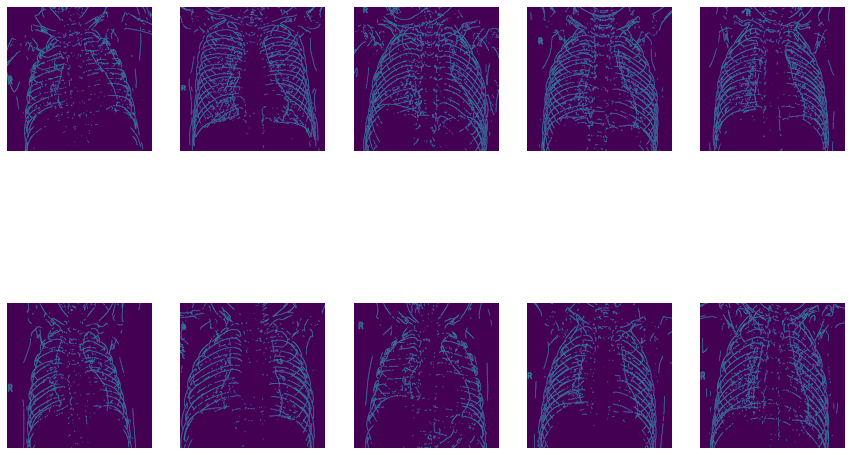

In [21]:
fig=plt.figure(figsize=(15, 10))
columns = 5; rows = 2
for i in range(1, columns*rows +1):
    img = cv2.imread(images[i])
    img = cv2.resize(img, (512, 512))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(img, 80, 100)
    fig.add_subplot(rows, columns, i)
    plt.imshow(edges)
    plt.axis(False)

# Modelling

## Dataset

In [22]:
# Define Training and Validation Data Generator with Augmentations
train_gen = ImageDataGenerator(
    rescale=1/255.,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.4,
    zoom_range=0.4
)
val_gen = ImageDataGenerator(
    rescale=1/255.,
)

In [24]:
# Flow the data into the Data Generator
Train = train_gen.flow_from_directory(
    "./input/chest_xray/train",
    target_size=(224, 224),
    batch_size=16
)
Test = train_gen.flow_from_directory(
    "./input/chest_xray/test",
    target_size=(224, 224),
    batch_size=8
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## model_cnn

In [25]:
model = Sequential()
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

In [26]:
# Compile the model and see it's structure and parameters
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 64)        73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 26, 26, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        1

## Train 학습

In [27]:
hist = model.fit_generator(
    Train,
    epochs=20,
    validation_data=Test
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
326/326 [==============================] - 531s 2s/step - loss: 0.4659 - accuracy: 0.7820 - val_loss: 0.5244 - val_accuracy: 0.7772
Epoch 2/20
326/326 [==============================] - 524s 2s/step - loss: 0.3574 - accuracy: 0.8413 - val_loss: 0.4680 - val_accuracy: 0.7917
Epoch 3/20
326/326 [==============================] - 524s 2s/step - loss: 0.3085 - accuracy: 0.8669 - val_loss: 0.4124 - val_accuracy: 0.8173
Epoch 4/20
326/326 [==============================] - 524s 2s/step - loss: 0.2814 - accuracy: 0.8763 - val_loss: 0.4809 - val_accuracy: 0.7949
Epoch 5/20
326/326 [==============================] - 523s 2s/step - loss: 0.2674 - accuracy: 0.8848 - val_loss: 0.3989 - val_accuracy: 0.8189
Epoch 6/20
326/326 [==============================] - 522s 2s/step - loss: 0.2391 - accuracy: 0.9013 - val_loss: 0.5273 - val_accuracy: 0.7692
Epoch 7/20
326/326 [==============================] - 522s 2s/step

In [29]:
print("Loss of the model is - " , model.evaluate(Test)[0])
#
print("Accuracy of the model is - " , model.evaluate(Test)[1]*100 , "%")
#91..?

78/78 [==============================] - 20s 260ms/step - loss: 0.3646 - accuracy: 0.8830
Loss of the model is -  0.36460843682289124
78/78 [==============================] - 20s 260ms/step - loss: 0.3884 - accuracy: 0.8590
Accuracy of the model is -  85.89743375778198 %
